# Deep Fakes (2/3) - Training stage

This notebook is part of a group of notebooks that together belong to a Deep Fakes article. I try to teach all of you how to build Autoencoders for Deep Fakes from scratch.

In this particular notebook, I'll go across several steps to train the autoencoders for Deep Fakes: Using the proprocessed data obtained in the [previous notebook](https://www.kaggle.com/sergiovirahonda/deepfakes-preprocessing), I train two Convolutional Autoencoders to then swap their encoders and decoders to generate faces with the destination facial features but with the gestures of source faces. Once this notebook ends the training, you can download the resulting models to continue locally, use this notebook output as the input of the [next one](https://www.kaggle.com/sergiovirahonda/deepfakes-face-swapping) or if you want to train the models for more epochs and obtain much better results, I'd suggest you to check [this repo](https://github.com/sergiovirahonda/DeepFakesTrainingContainer) which contains the necessary stuff to train these models on Google Cloud Platforms with a Docker Container.

Regarding the data used, I've obtained videos with Creative Commons Attribution Licenses and therefore reuseing them is totally allowed.

# Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/faceswap2/FaceSwap/Vinsuka/1269.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/623.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/764.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1075.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/771.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/208.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/820.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/473.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1411.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1031.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1385.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1383.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/333.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1354.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/1024.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/537.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/45.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/369.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/56.jpg
/kaggle/input/faceswap2/FaceSwap/Vinsuka/654.jpg
/kaggle/input/

# Dataset creation

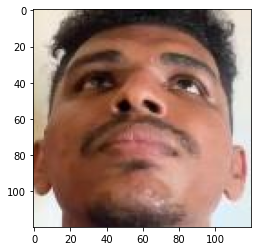

In [3]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/input/faceswap2/FaceSwap/Dulaj/1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')
image /= 255.0
plt.imshow(image)
plt.show()

In [4]:
def create_dataset(path):
    images = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirname, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype('float32')
            image /= 255.0
            images.append(image)
    images = np.array(images)
    return images

In [5]:
faces_1 = create_dataset('/kaggle/input/faceswap2/FaceSwap/Dulaj/')
faces_2 = create_dataset('/kaggle/input/faceswap2/FaceSwap/Vinsuka/')

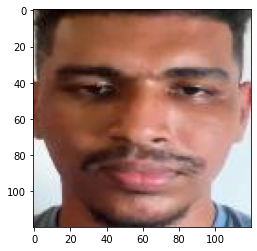

In [6]:
%matplotlib inline
plt.figure()
plt.imshow(faces_1[1])
plt.show()

In [7]:
print("Total Dulaj face's samples: ",len(faces_1))
print("Total Vinsuka face's samples: ",len(faces_2))

Total Dulaj face's samples:  2407
Total Vinsuka face's samples:  1452


# Dataset splitting

In [8]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(faces_1, faces_1, test_size=0.20, random_state=0)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(faces_2, faces_2, test_size=0.15, random_state=0)

In [9]:
X_train_a[0].shape

(120, 120, 3)

# Creating and training the autoencoders

In [10]:
#Making encoder:

input_img = layers.Input(shape=(120, 120, 3))
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(9216)(x)
encoded = layers.Reshape((3,3,1024))(x)

encoder = keras.Model(input_img, encoded,name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 256)       19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 512)       3277312   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 1024)        13108224  
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 1024)        0   

In [11]:
#Making decoder:
decoder_input= layers.Input(shape=((3,3,1024)))
x = layers.Conv2D(1024,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((120, 120, 3)))(x)
decoded = layers.Reshape((120, 120, 3))(x)

decoder = keras.Model(decoder_input, decoded,name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 3, 1024)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 1024)        26215424  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 512)         13107712  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 256)         3277056   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0   

In [12]:
#Making autoencoder
auto_input = layers.Input(shape=(120,120,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)

autoencoder = keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 3, 3, 1024)        54162944  
_________________________________________________________________
decoder (Functional)         (None, 120, 120, 3)       86880192  
Total params: 141,043,136
Trainable params: 141,043,136
Non-trainable params: 0
_________________________________________________________________


In [13]:
checkpoint1 = ModelCheckpoint("/kaggle/working/autoencoder_a.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = autoencoder.fit(X_train_a, X_train_a,epochs=2700,batch_size=512,shuffle=True,validation_data=(X_test_a, X_test_a),callbacks=[checkpoint1])

Epoch 1/2700
4/4 [==============================] - ETA: 0s - loss: 0.4716
Epoch 00001: val_loss improved from inf to 0.47062, saving model to /kaggle/working/autoencoder_a.hdf5
4/4 [==============================] - 11s 3s/step - loss: 0.4716 - val_loss: 0.4706
Epoch 2/2700
4/4 [==============================] - ETA: 0s - loss: 0.4712
Epoch 00002: val_loss improved from 0.47062 to 0.46934, saving model to /kaggle/working/autoencoder_a.hdf5
4/4 [==============================] - 8s 2s/step - loss: 0.4712 - val_loss: 0.4693
Epoch 3/2700
4/4 [==============================] - ETA: 0s - loss: 0.4569
Epoch 00003: val_loss improved from 0.46934 to 0.37901, saving model to /kaggle/working/autoencoder_a.hdf5
4/4 [==============================] - 9s 2s/step - loss: 0.4569 - val_loss: 0.3790
Epoch 4/2700
4/4 [==============================] - ETA: 0s - loss: 0.3408
Epoch 00004: val_loss improved from 0.37901 to 0.27262, saving model to /kaggle/working/autoencoder_a.hdf5
4/4 [==================

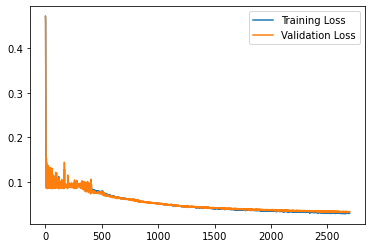

In [14]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()

In [15]:
autoencoder_a = load_model("/kaggle/working/autoencoder_a.hdf5")
autoencoder_a.evaluate(X_test_a, X_test_a)

16/16 [==============================] - 1s 32ms/step - loss: 0.0314


0.031449079513549805

In [16]:
output_image = autoencoder_a.predict(np.array([X_test_a[30]]))

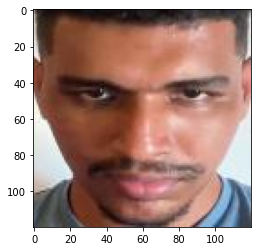

In [17]:
%matplotlib inline
plt.figure()
plt.imshow(X_test_a[30])
plt.show()

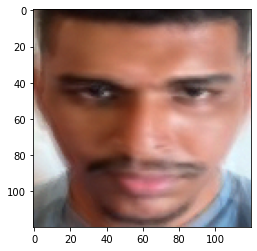

In [18]:
%matplotlib inline
plt.figure()
plt.imshow(output_image[0])
plt.show()

In [19]:
# TO LOAD ONLY THE ENCODER A
encoder_a = keras.Model(autoencoder_a.layers[1].input, autoencoder_a.layers[1].output)
# TO LOAD ONLY THE DECODER A
decoder_a = keras.Model(autoencoder_a.layers[2].input, autoencoder_a.layers[2].output)

In [20]:
input_test = encoder_a.predict(np.array([X_test_a[30]]))
output_test = decoder_a.predict(input_test)
output_test = decoder_a.predict(input_test)

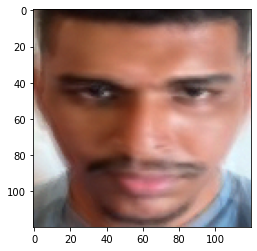

In [21]:
%matplotlib inline
plt.figure()
plt.imshow(output_test[0])
plt.show()

In [22]:
import gc
gc.collect()

13926

In [23]:
checkpoint2 = ModelCheckpoint("/kaggle/working/autoencoder_b.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history2 = autoencoder.fit(X_train_b, X_train_b,epochs=2700,batch_size=512,shuffle=True,validation_data=(X_test_b, X_test_b),callbacks=[checkpoint2])

Epoch 1/2700
3/3 [==============================] - ETA: 0s - loss: 0.1773
Epoch 00001: val_loss improved from inf to 0.14197, saving model to /kaggle/working/autoencoder_b.hdf5
3/3 [==============================] - 9s 3s/step - loss: 0.1773 - val_loss: 0.1420
Epoch 2/2700
3/3 [==============================] - ETA: 0s - loss: 0.1385
Epoch 00002: val_loss improved from 0.14197 to 0.11038, saving model to /kaggle/working/autoencoder_b.hdf5
3/3 [==============================] - 9s 3s/step - loss: 0.1385 - val_loss: 0.1104
Epoch 3/2700
3/3 [==============================] - ETA: 0s - loss: 0.1112
Epoch 00003: val_loss improved from 0.11038 to 0.09964, saving model to /kaggle/working/autoencoder_b.hdf5
3/3 [==============================] - 7s 2s/step - loss: 0.1112 - val_loss: 0.0996
Epoch 4/2700
3/3 [==============================] - ETA: 0s - loss: 0.0993
Epoch 00004: val_loss improved from 0.09964 to 0.09660, saving model to /kaggle/working/autoencoder_b.hdf5
3/3 [===================

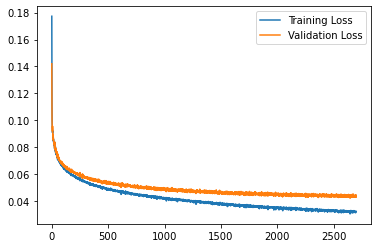

In [24]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()

In [25]:
autoencoder_b = load_model("/kaggle/working/autoencoder_b.hdf5")
autoencoder_b.evaluate(X_test_b, X_test_b)

7/7 [==============================] - 0s 43ms/step - loss: 0.0421


0.04214181751012802

In [26]:
output_image = autoencoder_b.predict(np.array([X_test_b[0]]))

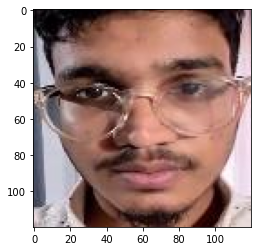

In [27]:
%matplotlib inline
plt.figure()
plt.imshow(X_test_b[0])
plt.show()

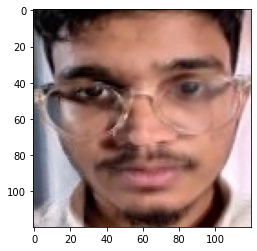

In [28]:
%matplotlib inline
plt.figure()
plt.imshow(output_image[0])
plt.show()

# Downloading the trained models

In case your autoencoder_a file doesn't download from the right panel, use this link -> 
<a href="./autoencoder_a.hdf5"> Download File </a>

In case your autoencoder_b file doesn't download from the right panel, use this link -> 
<a href="./autoencoder_b.hdf5"> Download File </a>